# Import Libraries

**First, we need to import the necessary libraries for this task.**

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D, Lambda, Input, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import itertools
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from itertools import cycle
from scipy import interp
from sklearn import metrics
from keras.models import load_model
import os
import cv2
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [9]:
img_width, img_height = 64, 64
train_data_dir = '../input/chest-xray-pneumonia/chest_xray/train'
test_data_dir = '../input/chest-xray-pneumonia/chest_xray/test'
nb_train_samples = 5216
nb_validation_samples = 624
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Data Augmentation


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, #rescales each images (normalization)
    shear_range=0.2,  #shears each images by 0.2%
    zoom_range=0.2, # zoom each image by 0.2%
    width_shift_range=0.2,  #shifts width
    height_shift_range=0.2,  #shifts height
    horizontal_flip=False,  #horizontally flips the images
    vertical_flip=False)
test_datagen = ImageDataGenerator(rescale=1. / 255)  #no augmentation is performed for test set except for the normalization.


**Creates batches for training, validation and testing**

In [11]:
train_batches = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')  #class mode is set to binary as we are performing binary classification.

Found 5216 images belonging to 2 classes.


In [13]:
test_batches = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=624,
    class_mode='categorical')   #class mode is set to binary as we are performing binary classification.

Found 624 images belonging to 2 classes.


# Model



# Avoid Overfitting

**To avoid the famous over-fitting problem, We used the dropout regularization method. Dropout means it disables a percentage of neurons from extracting unneccessary features.** 

In [28]:
epochs = 20
INIT_LR = 0.0001
opt = Adam(lr=INIT_LR, decay=INIT_LR / epochs)

In [29]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 2
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()
    model[j].add(BatchNormalization(input_shape=input_shape))
    model[j].add(Conv2D(32, (3, 3), padding='valid'))
    #model[j].add(BatchNormalization())
    model[j].add(Activation('relu'))
    #model[j].add(Dropout(0.4))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    model[j].add(Dropout(0.5))
    
    model[j].add(Conv2D(32, (5, 5), padding='same'))
    #model[j].add(BatchNormalization())
    model[j].add(Activation('relu'))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    
    model[j].add(Conv2D(64, (5, 5), padding='same'))
    #model[j].add(BatchNormalization())
    model[j].add(Activation('relu'))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    
    model[j].add(Conv2D(128, (5, 5), padding='same'))
    #model[j].add(BatchNormalization())
    model[j].add(Activation('relu'))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    
    model[j].add(Flatten())
    #model[j].add(Dense(128))
    #model[j].add(Activation('relu'))
    model[j].add(Dense(256))
    model[j].add(Activation('relu'))
    model[j].add(Dropout(0.5))
    #model[j].add(Dense(32))
    #model[j].add(Activation('relu'))

    model[j].add(Dense(2))
    model[j].add(Activation('softmax'))
    model[j].summary()

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
activation_60 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 31, 31, 32)        25632     
_________________________________________________________________
activation_61 (Activation)   (None, 31, 31, 32)      

In [30]:
# DECREASE LEARNING RATE EACH EPOCH
#annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
for j in range(nets):
    #X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(train_batches,
        epochs = epochs, steps_per_epoch = nb_train_samples // batch_size,
        validation_data = test_batches,
        validation_steps = nb_validation_samples // batch_size,
        callbacks=[#annealer,
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
        tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
        ])  #, callbacks=[annealer]
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Epoch 1/20
81/81 [==============================] - 101s 1s/step - loss: 0.5700 - accuracy: 0.7422 - val_loss: 0.6625 - val_accuracy: 0.6250
Epoch 2/20
81/81 [==============================] - 101s 1s/step - loss: 0.4106 - accuracy: 0.8228 - val_loss: 0.6105 - val_accuracy: 0.6731
Epoch 3/20
81/81 [==============================] - 101s 1s/step - loss: 0.3211 - accuracy: 0.8635 - val_loss: 0.4713 - val_accuracy: 0.8093
Epoch 4/20
81/81 [==============================] - 101s 1s/step - loss: 0.2856 - accuracy: 0.8830 - val_loss: 0.3886 - val_accuracy: 0.8670
Epoch 5/20
81/81 [==============================] - 101s 1s/step - loss: 0.2614 - accuracy: 0.8903 - val_loss: 0.3784 - val_accuracy: 0.8750
Epoch 6/20
81/81 [==============================] - 100s 1s/step - loss: 0.2531 - accuracy: 0.8964 - val_loss: 0.4382 - val_accuracy: 0.8413
Epoch 7/20
81/81 [==============================] - 101s 1s/step - loss: 0.2392 - accuracy: 0.9049 - val_loss: 0.3386 - val_accuracy: 0.8830
Epoch 8/20
81

In [38]:
test_imgs, test_labels = next(test_batches)

In [59]:
results = np.zeros( (624,2) ) 
for j in range(nets):
    results = results + model[j].predict_generator(test_imgs, steps=1, verbose=0)
results = np.argmax(results,axis = -1)


In [40]:
results

array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,

In [43]:
test_labels = np.argmax(test_labels,axis = -1)
test_labels

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,

In [44]:
cm = confusion_matrix(y_true=test_labels, y_pred=results)

**Accuracy**

In [60]:
acc = accuracy_score(test_labels, results)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall: {0:0.2f}%'.format(recall))
print('F1-score: {0:0.2f}'.format(2*precision*recall/(precision+recall)))


Accuracy: 90.87%
Precision: 90.91%
Recall: 94.87%
F1-score: 92.85


In [47]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[197  37]
 [ 20 370]]


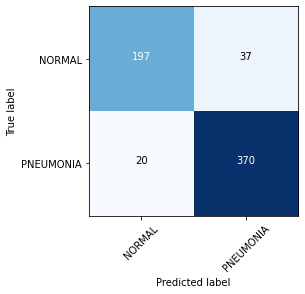

In [48]:
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [49]:
from sklearn.metrics import classification_report

In [53]:
print(classification_report(y_true=test_labels, y_pred=results))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       234
           1       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



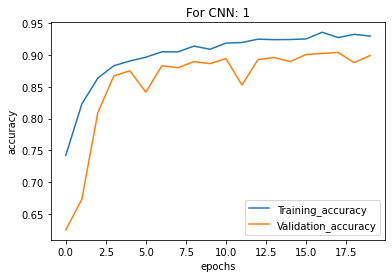

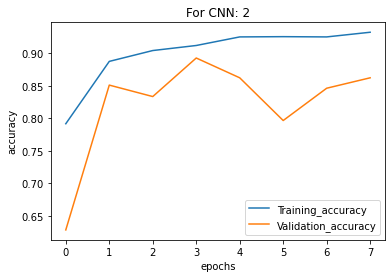

In [55]:
for j in range(nets):
    accs = history[j].history['accuracy']
    val_accs = history[j].history['val_accuracy']

    plt.title("For CNN: "+ str(j+1))
    plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
    plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

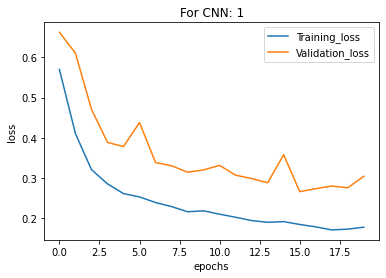

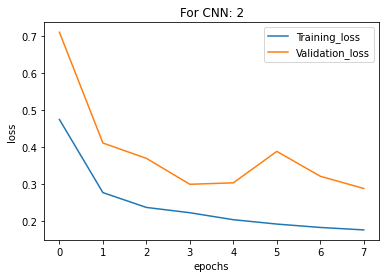

In [52]:
for j in range(nets):
    loss = history[j].history['loss']
    val_loss = history[j].history['val_loss']

    plt.title("For CNN: "+ str(j+1))
    plt.plot(range(len(loss)),loss, label = 'Training_loss')
    plt.plot(range(len(loss)),val_loss, label = 'Validation_loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()